In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections

In [2]:
# parametros da simulacao
nx = 4
ny = 4
Lx = 1.0
Ly = 1.0
alpha = 1.0
rho = 1.0
cv = 1.0
q = 0.0
npoints = nx*ny
ne = (nx-1)*(ny-1)
# Parâmetro Beta
# --------------
# beta = 0 -> Método Explícito (1º Ordem)
# beta = 1 -> Método Implícito (1º Ordem)
# beta = 1/2 -> Crank-Nicholson (2º Ordem)

beta = 1.0
dt = 0.5
nIter = 10

# geracao de pontos e malha
Xv = np.linspace(0,Lx,nx)
Yv = np.linspace(0,Ly,ny)

X,Y = np.meshgrid(Xv,Yv)
X = np.reshape(X,npoints)
Y = np.reshape(Y,npoints)

IEN = np.zeros( (ne,4),dtype='int' )
for i in range(0,ne):
    j = i//(nx-1)
    IEN[i] = [i+j,i+1+j,i+(nx+1)+j,i+(nx)+j]

In [3]:
# Pontos C.C
cc1 = [];cc2 = [];cc3 = [];cc4 = []; cc = []; noncc = []

for i in range(0,npoints):
    if Y[i] == min(Y):
        cc1.append(i)
        cc.append(i)
    elif Y[i] == max(Y):
        cc3.append(i)
        cc.append(i)
    elif X[i] == min(X) and Y[i]>min(Y) and Y[i]<max(Y):
        cc4.append(i)
        cc.append(i)
    elif X[i] == max(X) and Y[i]>min(Y) and Y[i]<max(Y): 
        cc2.append(i)
        cc.append(i)
    else:
        noncc.append(i)

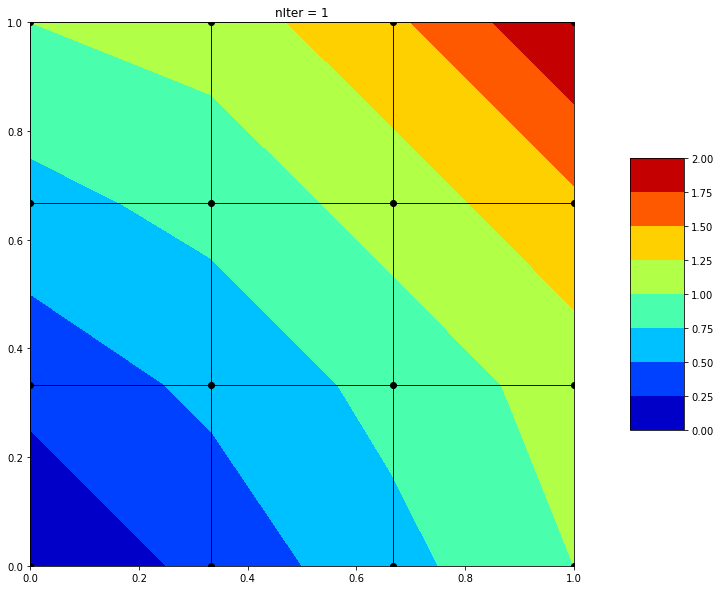

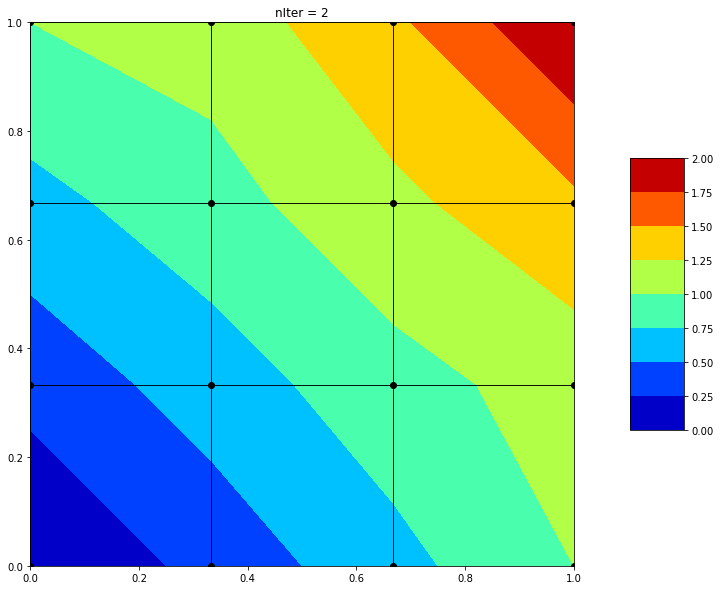

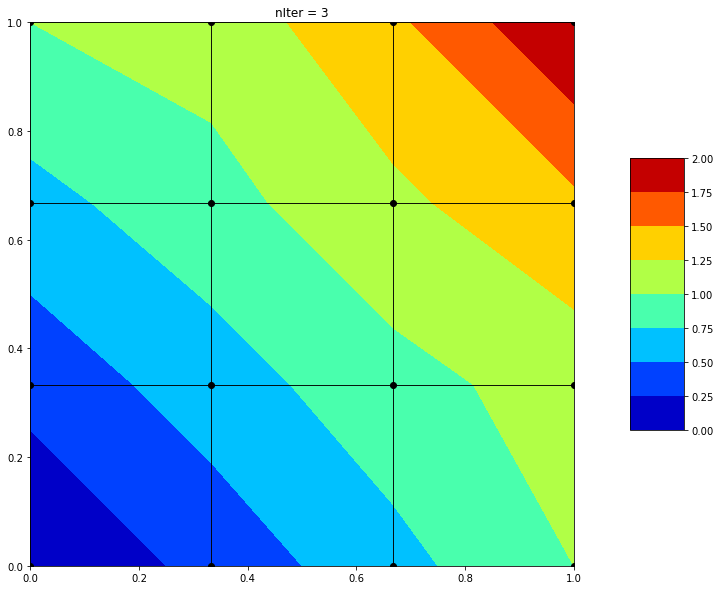

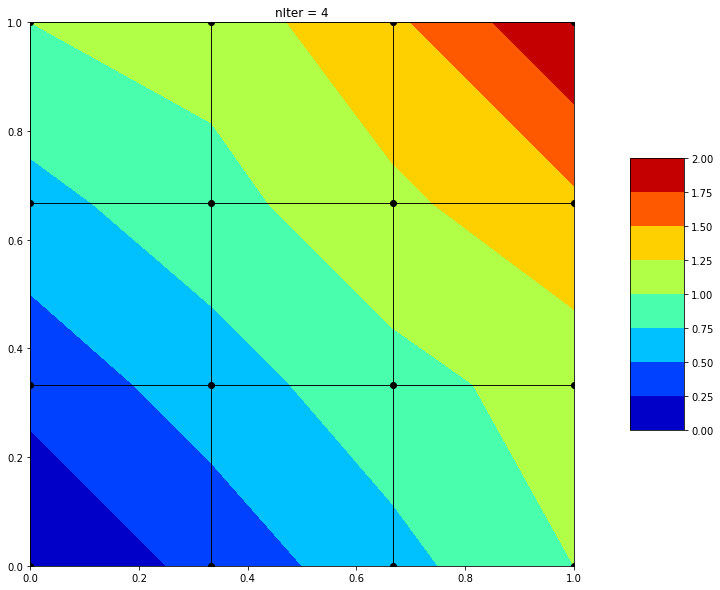

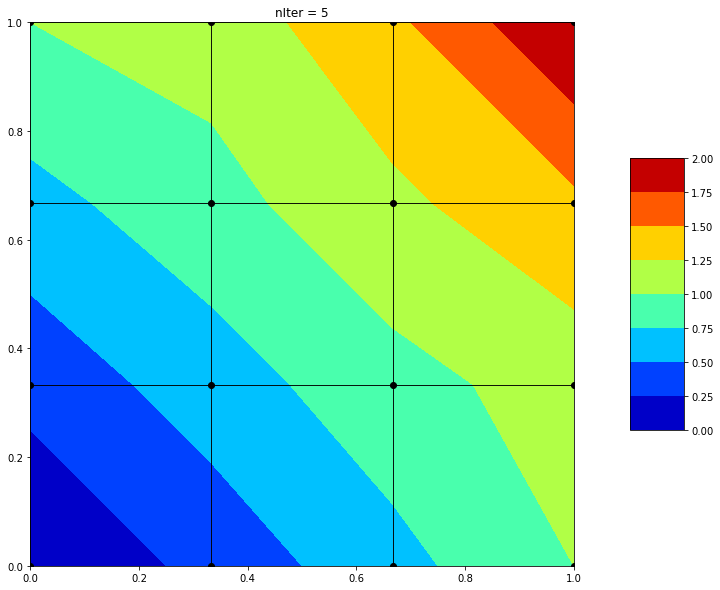

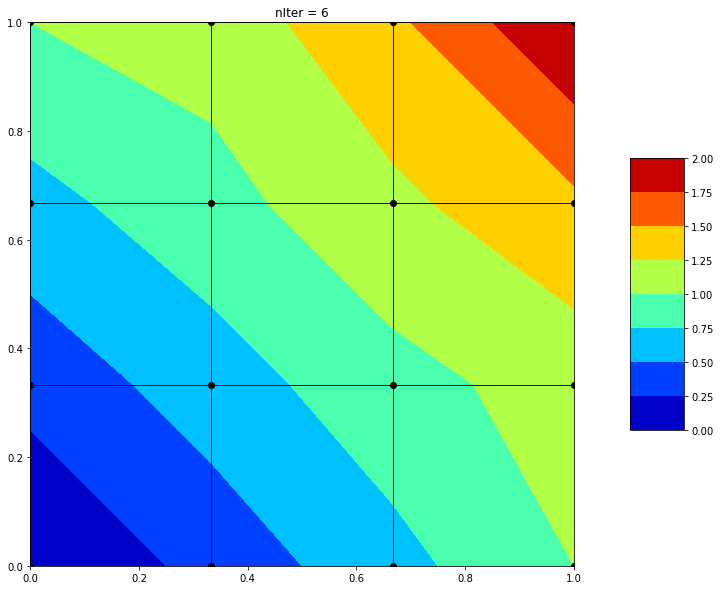

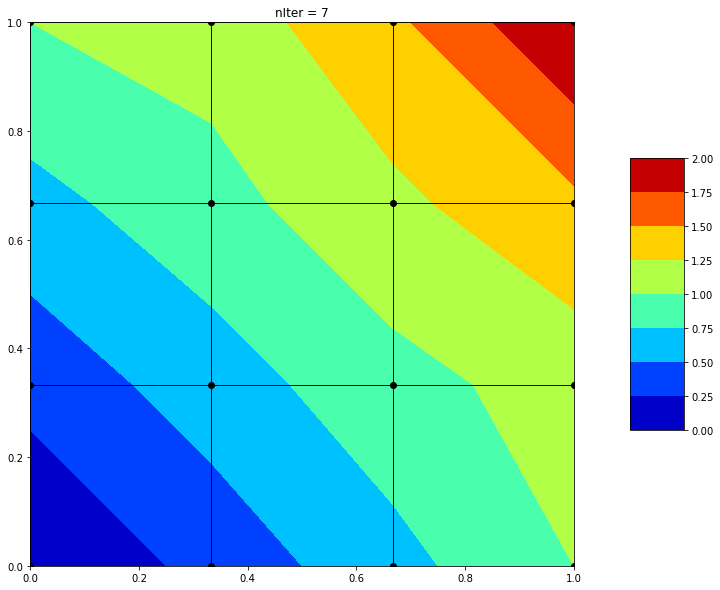

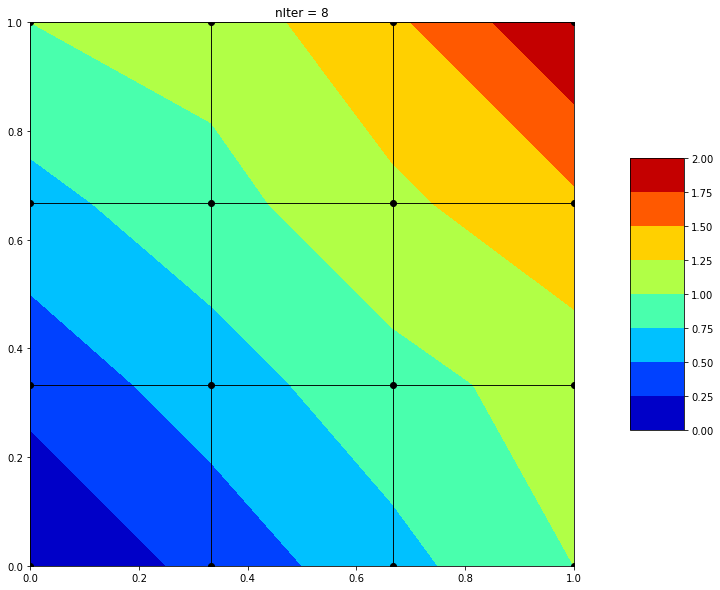

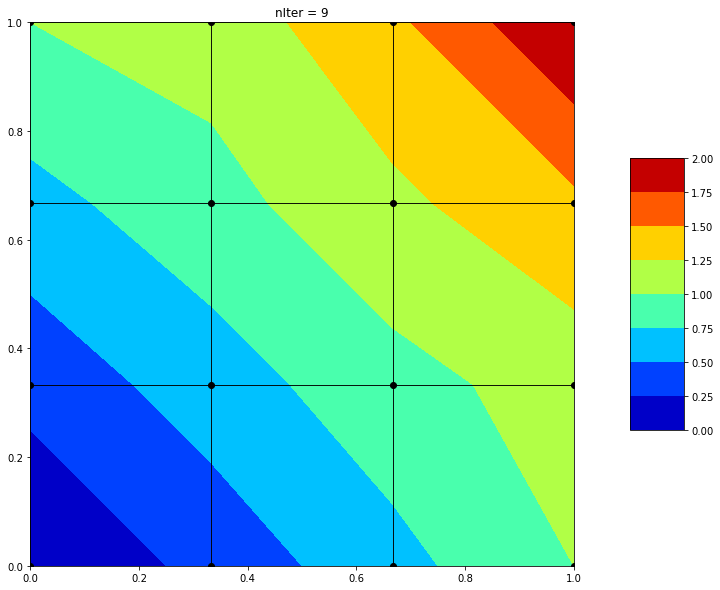

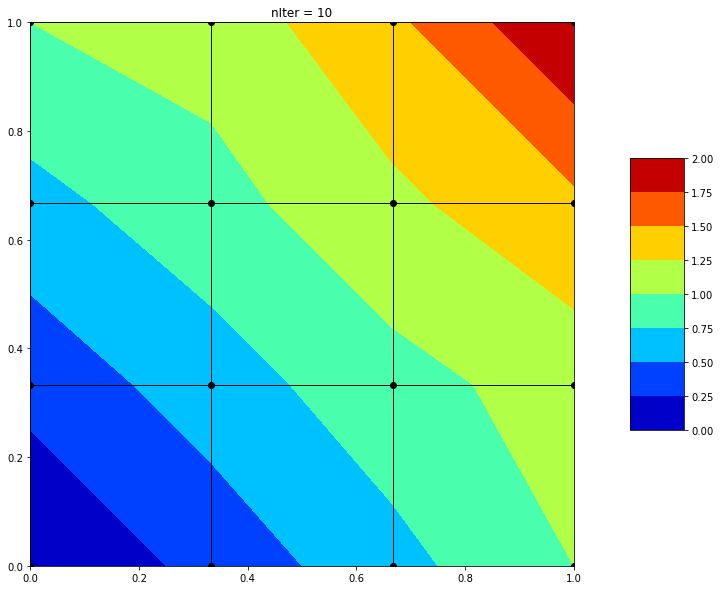

In [4]:
# construcao das matrizes K, M e Q
Q = (q/(rho*cv))*np.ones( (npoints),dtype='float' )
K = np.zeros( (npoints,npoints),dtype='float' )
M = np.zeros( (npoints,npoints),dtype='float' )

for e in range(0,ne):
    # definicao das matrizes do elemento
    v1,v2,v3,v4 = IEN[e]
    a = ( X[v2]-X[v1] )/2.0
    b = ( Y[v3]-Y[v2] )/2.0
    area = 4*a*b
    
    melem = (2*a*b/18.0)*np.array([[4.0,2.0,1.0,2.0],
                                [2.0,4.0,2.0,1.0],
                                [1.0,2.0,4.0,2.0],
                                [2.0,1.0,2.0,4.0] ])
    kxelem = (b/(6.0*a))*np.array([[ 2.0,-2.0,-1.0, 1.0],
                                [-2.0, 2.0, 1.0,-1.0],
                                [-1.0, 1.0, 2.0,-2.0],
                                [ 1.0,-1.0,-2.0, 2.0] ])
    kyelem = (a/(6.0*b))*np.array([[ 2.0, 1.0,-1.0,-2.0],
                                [ 1.0, 2.0,-2.0,-1.0],
                                [-1.0,-2.0, 2.0, 1.0],
                                [-2.0,-1.0, 1.0, 2.0] ])
    kelem = alpha*(kxelem+kyelem)

    for ilocal in range(0,4):
        iglobal = IEN[e,ilocal]
        for jlocal in range(0,4):
            jglobal = IEN[e,jlocal]

            K[iglobal,jglobal] += kelem[ilocal,jlocal]
            M[iglobal,jglobal] += melem[ilocal,jlocal]

A = M/dt + beta*K

# imposicao das condicoes de contorno de Dirichlet
for i in cc:
    A[i,:]   = 0.0   # zerando a linha 0
    A[i,i]   = 1.0   # colocando 1 na diagonal principal 0  

T = np.zeros((npoints),dtype='float' )
for i in cc1:
    T[i] = X[i]
for i in cc2:
     T[i] = Y[i]*Y[i]+1
for i in cc3:
     T[i] = X[i]*X[i]+1
for i in cc4:
     T[i] = Y[i]

for n in range(0,nIter):
    
    b = (M/dt - (1.0-beta)*K )@T + M@Q
    # c.c.
    for i in cc1:
        b[i] = X[i]
    for i in cc2:
        b[i] = Y[i]*Y[i]+1
    for i in cc3:
        b[i] = X[i]*X[i]+1
    for i in cc4:
        b[i] = Y[i] 

    T = np.linalg.solve(A,b)
    # plot da solucao
    xy = np.stack((X, Y), axis=-1)
    verts = xy[IEN]
    plt.figure(figsize=(20, 10))
    ax = plt.axes()
    ax.set_aspect('equal')
    xq = X.reshape(ny,nx)
    yq = Y.reshape(ny,nx)
    solq = T.reshape(ny,nx)
    surf = ax.contourf(xq,yq,solq,cmap='jet')
    plt.colorbar(surf,shrink=0.5, aspect=5)
    plt.title(f'nIter = {n+1}')
    ax=plt.gca()
    pc = matplotlib.collections.PolyCollection(verts,edgecolors=('black',),
                                                     facecolors= 'None',
                                                     linewidths=(0.7,))
    ax.add_collection(pc)
    plt.plot(X,Y,"ko")
    plt.show()